In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


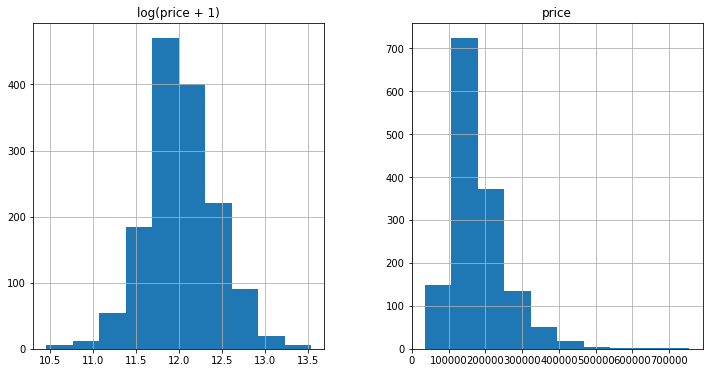

In [4]:
# Preprocess Data for SKLearn

train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

display(all_data.head())

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

In [5]:
# Ridge Regression Model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def gen_csv(filename, model):
    df = pd.DataFrame({"Id": test["Id"], "SalePrice": np.expm1(model.predict(X_test))})
    display(df.head())
    df.to_csv(filename, encoding='utf-8', index=False)

model_ridge = Ridge(0.1)
model_ridge.fit(X_train, y)

print("RMSE Error for a=1: {0}".format(rmse_cv(model_ridge).mean()))

gen_csv("out/df_a1.csv", model_ridge)

RMSE Error for a=1: 0.1377753827718782


,Id,SalePrice
0,1461,121519.486569
1,1462,159637.898351
2,1463,187900.728019
3,1464,200719.158085
4,1465,199280.934855


In [6]:
# Lasso Model

model_ridge_cv = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5).fit(X_train, y)
model_lasso_cv = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5).fit(X_train, y)

print("RMSE for Ridge regression: {0}".format(rmse_cv(model_ridge_cv).mean()))
print("RMSE for Lasso regression: {0}".format(rmse_cv(model_lasso_cv).mean()))

gen_csv("out/df_best_ridge.csv", model_ridge_cv)
gen_csv("out/df_best_lasso.csv", model_lasso_cv)

RMSE for Ridge regression: 0.1313618498939958
RMSE for Lasso regression: 0.1225673588504815


,Id,SalePrice
0,1461,120420.655489
1,1462,153867.564298
2,1463,185515.001785
3,1464,199064.684452
4,1465,201164.850838


,Id,SalePrice
0,1461,119958.035681
1,1462,151482.567322
2,1463,180200.853648
3,1464,197515.619193
4,1465,202434.157491


#### Kaggle Score for Best Ridge Regression
`0.12661`

#### Kaggle Score for Best Lasso Regression
`0.12096`

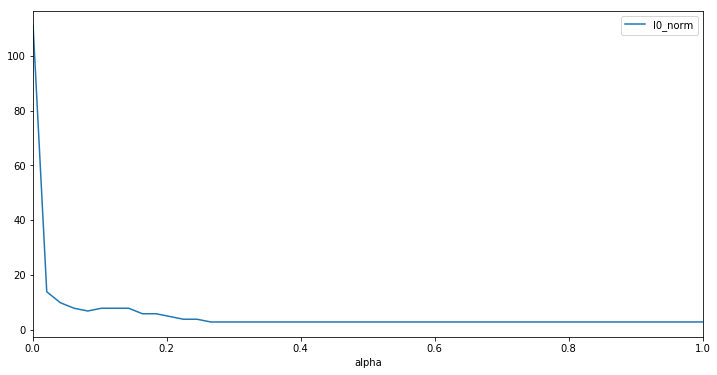

In [7]:
# alphas = [1, 0.1, 0.001, 0.0005]

l0_norm = []

pnts = np.linspace(0.0005,1,50)
for alpha in pnts:
    m_r = Lasso(alpha).fit(X_train, y)
    l0_norm.append({"alpha": alpha, "l0_norm": sum(m_r.coef_ != 0)})

pd.DataFrame(l0_norm).set_index("alpha").plot()
plt.show()

In [54]:
# Ensembling
from mlxtend.regressor import StackingRegressor

mre = RidgeCV(alphas = [2, 1, 0.1, 0.001, 0.0005], cv = 5).fit(X_train, y)
mle = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5).fit(X_train, y)
# meta_ridge = RidgeCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5)

X_ensemble_train = X_train.copy()
X_ensemble_train["ridge_prediction_1"] = np.expm1(mre.predict(X_train))
X_ensemble_train["lasso_prediction_1"] = np.expm1(mle.predict(X_train))

ridge_ensemble = RidgeCV(alphas = [2, 1, 0.1, 0.001, 0.0005], cv = 5).fit(X_ensemble_train, y)

# stacked = StackingRegressor(regressors=[ensemble_ridge, ensemble_lasso], 
#                            meta_regressor=meta_ridge)


# stacked.fit(X_train, y)

print("RMSE for Ensemble: {0}".format(rmse_cv(stacked).mean()))
gen_csv("out/df_ensemble_stack.csv", stacked)

X_ensemble_test = X_test.copy()
X_ensemble_test["ridge_prediction_1"] = np.expm1(mre.predict(X_test))
X_ensemble_test["lasso_prediction_1"] = np.expm1(mle.predict(X_test))

ensemble_df = pd.DataFrame({"Id": test["Id"], "SalePrice": np.expm1(ridge_ensemble.predict(X_ensemble_test))})

ensemble_df.to_csv("out/df_ensemble.csv", encoding='utf-8', index=False)

rmse = np.sqrt(-cross_val_score(ridge_ensemble, X_ensemble_train, y, scoring="neg_mean_squared_error", cv = 5))
print("Ensemble Model RMSE: {0}".format(rmse.mean()))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.48063e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.678e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.67239e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.3158e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=4.57246e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning:

RMSE for Ensemble: 0.1312331594847445


,Id,SalePrice
0,1461,120040.851562
1,1462,159583.609375
2,1463,188186.312500
3,1464,192737.625000
4,1465,178818.031250


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.92845e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.90386e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.80662e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.52061e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.4906e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarnin

Ensemble Model RMSE: 0.12792655736024935


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.71774e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.71147e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=6.28964e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.53432e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.40294e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarni

#### Kaggle Score for Ensembling
`0.13184`

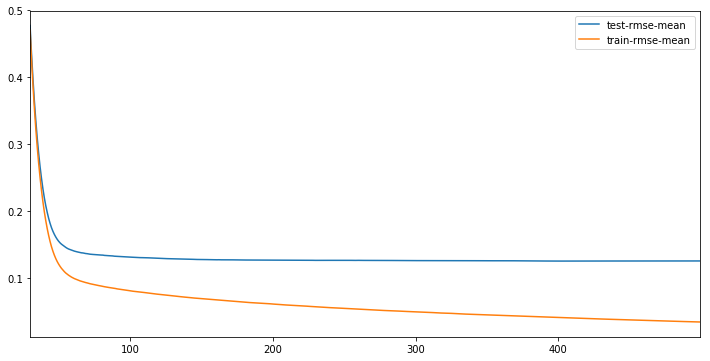

In [59]:
# XG BOOST
# First we need to tune parameters
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

# params = {"max_depth":2, "eta":0.1}
params = {'max_depth':3, 'eta':0.1, 'silent':1}

model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [55]:
model_xgb = xgb.XGBRegressor(n_estimators=600, max_depth=3, learning_rate=0.1) #the params were tuned using xgb.cv
# model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y)

print("RMSE for XGB: {0}".format(rmse_cv(model_xgb).mean()))
gen_csv("out/xgb_pred.csv", model_xgb)

KeyboardInterrupt: 

#### Kaggle score for XG Boost
`0.13414`

In [24]:
#Trying for best model

from mlxtend.regressor import StackingRegressor

# lasso_best = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv = 5)
# xgb_best = xgb.XGBRegressor(n_estimators=500, max_depth=2, learning_rate=0.1)

# meta_model = xgb.XGBRegressor(n_estimators=500, max_depth=2, learning_rate=0.1)

# stacked = StackingRegressor(regressors=[lasso_best, model_xgb], 
#                            meta_regressor=meta_model)


# stacked.fit(X_train, y)
# print("RMSE for Best: {0}".format(rmse_cv(stacked).mean()))
# gen_csv("out/best_pred.csv", model_xgb)


RMSE for Best: 0.1312331594847445


,Id,SalePrice
0,1461,120716.812500
1,1462,157959.515625
2,1463,186915.843750
3,1464,193784.687500
4,1465,184259.968750
